# Tutorial 3: Neural Ratio Estimation (NRE)
Credit: Tri Nguyen and Claude Code

In this tutorial, we'll implement neural ratio estimation (NRE) from scratch using PyTorch. NRE is a simulation-based inference method that uses a binary classifier to distinguish between samples from the joint distribution $p(x, \theta)$ and samples from the product of marginals $p(x)p(\theta)$.

**Setup**:
- Parameter: $\theta$ sampled from a prior distribution $p(\theta)$
- Simulator: $p(x|\theta)$ which implicitly defines the likelihood function
- Observation: $x \sim p(x|\theta)$
- Posterior: $p(\theta|x)$ (obtained via the learned ratio and sampling)

**Goal**: Learn a classifier $d_\phi(x, \theta)$ that distinguishes joint samples from independent samples. The classifier output is related to the posterior via:

$$p(\theta|x) \propto \frac{d_\phi(x, \theta)}{1 - d_\phi(x, \theta)} \cdot p(\theta)$$

where

$$d_\phi(x, \theta) = \frac{p(x, \theta)}{p(x, \theta)+ p(x)p(\theta)} = \frac{p(x |\theta)}{p(x |\theta) + p(x)}$$

**Key Difference from Previous Tutorials**:
- **Tutorial 1 (NPE)**: Directly learned $p(\theta|x)$, then sampled directly from the model
- **Tutorial 2 (NLE)**: Learned $p(x|\theta)$, then used MCMC/Nested Sampling
- **Tutorial 3 (NRE)**: Learns to classify joint vs independent samples, then uses MCMC/Nested Sampling

**Why NRE?** NRE can be more sample-efficient than NPE/NLE and doesn't require explicit density models or normalizing flows. However, it does require generating "negative" samples from the product of marginals $p(x)p(\theta)$.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Install sampling packages if needed
try:
    import emcee
    import dynesty
    print("✓ Sampling packages already installed")
except ImportError:
    print("Installing emcee and dynesty...")
    !pip install emcee dynesty
    import emcee
    import dynesty
    print("✓ Sampling packages installed")

from dynesty import NestedSampler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")

✓ Sampling packages already installed
Libraries imported successfully!


---
# Part 1: Ratio Estimation on Gaussian Data

We'll start with a simple case where the true distribution is Gaussian.

## 1. Generate the training data

We'll use the same Gaussian joint distribution from Tutorials 1 and 2. However, for NRE, we also need to generate **negative samples** from the product of marginals $p(x)p(\theta)$.

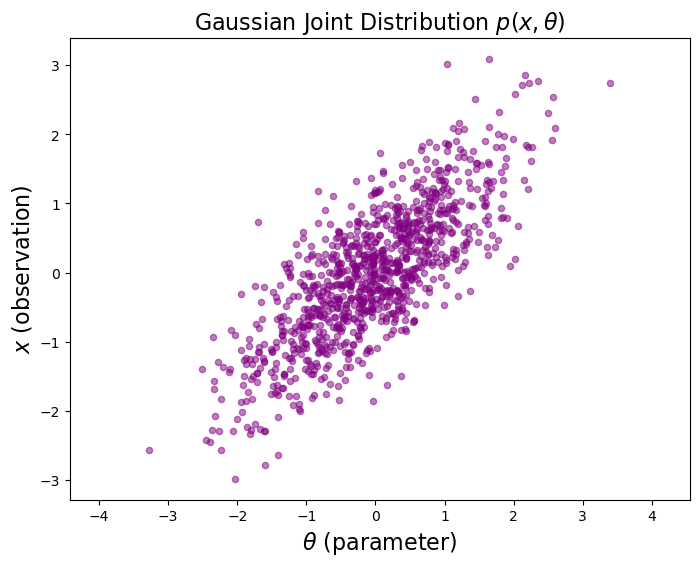

Sampled 1000 points from 2D Gaussian
Correlation between θ and x: 0.780


In [2]:
def sample_gaussian_joint(n_samples, mean=[0, 0], cov=[[1.0, 0.8], [0.8, 1.0]]):
    """
    Sample from a 2D Gaussian joint distribution p(x, θ).

    Parameters:
    - n_samples: number of samples
    - mean: [mean_theta, mean_x]
    - cov: 2x2 covariance matrix

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    theta = samples[:, 0]
    x = samples[:, 1]
    return theta, x

# Visualize the Gaussian joint distribution
theta_gauss_vis, x_gauss_vis = sample_gaussian_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_gauss_vis, x_gauss_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Gaussian Joint Distribution $p(x, \theta)$', fontsize=16)
plt.axis('equal')
plt.show()

print(f"Sampled {len(theta_gauss_vis)} points from 2D Gaussian")
print(f"Correlation between θ and x: {np.corrcoef(theta_gauss_vis, x_gauss_vis)[0,1]:.3f}")

In [3]:
# Generate training data from Gaussian
n_training = 10_000
mean = [0, 0]
cov = [[1.0, 0.8], [0.8, 1.0]]
print(f"Generating {n_training} training samples from Gaussian...\n")

# Positive samples: from joint p(x, θ)
theta_joint, x_joint = sample_gaussian_joint(n_training, mean=mean, cov=cov)

# Negative samples: from product of marginals p(x)p(θ)
# We can generate these by randomly shuffling one of the dimensions
theta_indep = theta_joint.copy()
x_indep = np.random.permutation(x_joint)  # shuffle x to break correlation

print(f"  Training data generated")
print(f"  Joint samples: {len(theta_joint)}")
print(f"  Independent samples: {len(theta_indep)}")
print(f"\nCorrelation in joint samples: {np.corrcoef(theta_joint, x_joint)[0,1]:.3f}")
print(f"Correlation in independent samples: {np.corrcoef(theta_indep, x_indep)[0,1]:.3f}")

Generating 10000 training samples from Gaussian...

  Training data generated
  Joint samples: 10000
  Independent samples: 10000

Correlation in joint samples: 0.810
Correlation in independent samples: -0.018


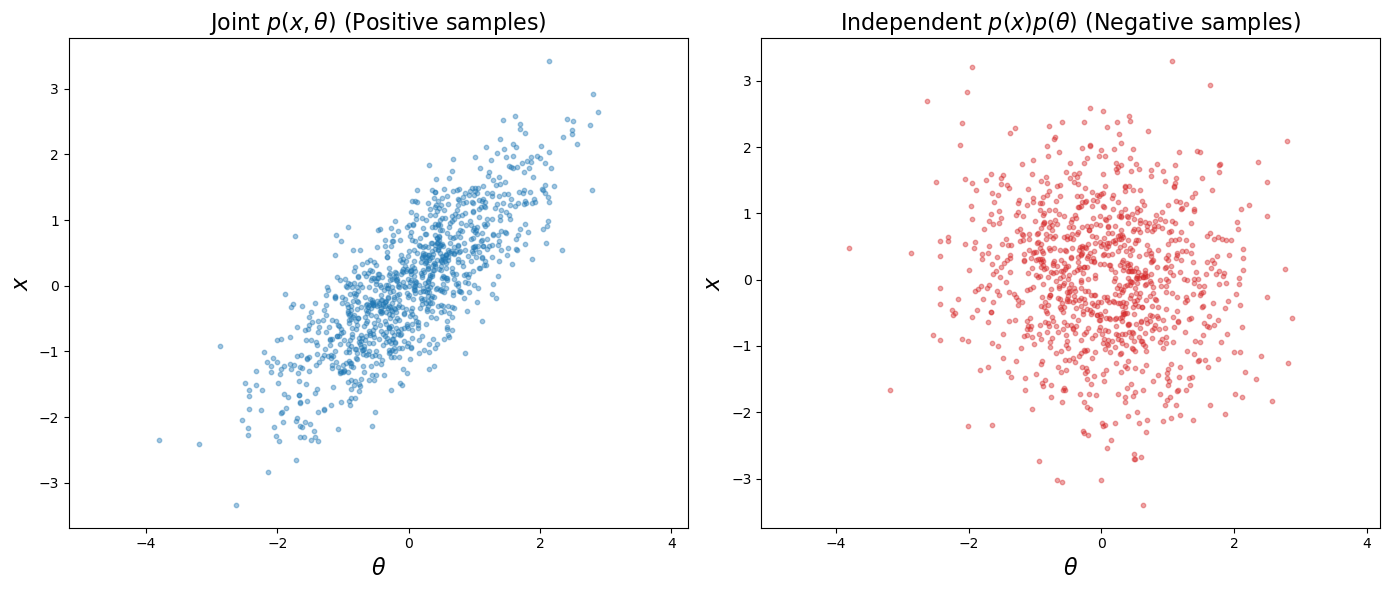

In [4]:
# Visualize joint vs independent samples
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(theta_joint[:1000], x_joint[:1000], alpha=0.4, s=10, color='C0', label='Joint')
axes[0].set_xlabel(r'$\theta$', fontsize=16)
axes[0].set_ylabel(r'$x$', fontsize=16)
axes[0].set_title(r'Joint $p(x, \theta)$ (Positive samples)', fontsize=16)
axes[0].axis('equal')

axes[1].scatter(theta_indep[:1000], x_indep[:1000], alpha=0.4, s=10, color='C3', label='Independent')
axes[1].set_xlabel(r'$\theta$', fontsize=16)
axes[1].set_ylabel(r'$x$', fontsize=16)
axes[1].set_title(r'Independent $p(x)p(\theta)$ (Negative samples)', fontsize=16)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

## 2. Build Ratio Estimator

The ratio estimator is a **binary classifier** that takes $(x, \theta)$ as input and outputs a probability:

$$d_\phi(x, \theta) = p(\text{joint} | x, \theta)$$

This probability is related to the density ratio:

$$d_\phi(x, \theta) = \frac{p(x, \theta)}{p(x, \theta) + p(x)p(\theta)}$$

From this, we can recover the likelihood ratio:

$$r(x, \theta) = \frac{p(x, \theta)}{p(x)p(\theta)} = \frac{d_\phi(x, \theta)}{1 - d_\phi(x, \theta)}$$

And since $p(x, \theta) = p(x|\theta)p(\theta)$ and $p(x)p(\theta) = p(x)p(\theta)$:

$$r(x, \theta) = \frac{p(x|\theta)}{p(x)} \propto p(\theta|x) / p(\theta)$$

Therefore, we can compute the unnormalized posterior:

$$p(\theta|x) \propto r(x, \theta) \cdot p(\theta)$$

In [5]:
class RatioEstimator(nn.Module):
    """
    Binary classifier for ratio estimation.

    Input: (x, θ) concatenated
    Output: probability that the sample is from the joint p(x, θ)
    """

    def __init__(self, hidden_size=64):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(2, hidden_size),  # input: [x, θ] concatenated
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # output probability in [0, 1]
        )

    def forward(self, x, theta):
        """Compute d(x, θ) = p(joint | x, θ)"""
        inputs = torch.cat([x, theta], dim=1)
        return self.network(inputs)

    def log_ratio(self, x, theta):
        """Compute log r(x, θ) = log[p(x,θ) / p(x)p(θ)]"""
        d = self.forward(x, theta)
        # Numerical stability: clamp d away from 0 and 1
        d = torch.clamp(d, 1e-7, 1 - 1e-7)
        return torch.log(d) - torch.log(1 - d)

ratio_estimator_gauss = RatioEstimator(hidden_size=64)

## 3. Training

We train the classifier using binary cross-entropy loss:

$$\mathcal{L}(\phi) = -\mathbb{E}_{p(x,\theta)}[\log d_\phi(x, \theta)] - \mathbb{E}_{p(x)p(\theta)}[\log(1 - d_\phi(x, \theta))]$$

where the first term is over joint samples (label=1) and the second term is over independent samples (label=0).

In [6]:
def train_ratio_estimator(model, theta_joint, x_joint, theta_indep, x_indep,
                         epochs=50, batch_size=256, lr=1e-3):
    """
    Train the ratio estimator (binary classifier).
    """
    # Prepare data: joint samples (label=1) and independent samples (label=0)
    theta_all = np.concatenate([theta_joint, theta_indep])
    x_all = np.concatenate([x_joint, x_indep])
    labels = np.concatenate([np.ones(len(theta_joint)), np.zeros(len(theta_indep))])

    # Convert to tensors
    theta_tensor = torch.tensor(theta_all, dtype=torch.float32).reshape(-1, 1)
    x_tensor = torch.tensor(x_all, dtype=torch.float32).reshape(-1, 1)
    labels_tensor = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

    dataset = TensorDataset(x_tensor, theta_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Instead of the negative log-likelihood, we use binary cross-entropy loss
    criterion = nn.BCELoss()

    losses = []
    accuracies = []
    print(f"Training for {epochs} epochs...\n")

    for epoch in range(epochs):
        epoch_loss = 0.0   # Cumulative loss for the epoch
        epoch_correct = 0   # Number of correct predictions
        epoch_total = 0
        n_batches = 0

        for x_batch, theta_batch, label_batch in dataloader:
            optimizer.zero_grad()

            # Forward pass
            pred = model(x_batch, theta_batch)
            loss = criterion(pred, label_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            epoch_loss += loss.item()
            epoch_correct += ((pred > 0.5).float() == label_batch).sum().item()
            epoch_total += len(label_batch)
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        accuracy = epoch_correct / epoch_total
        losses.append(avg_loss)
        accuracies.append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2%}")

    print("\n✓ Training complete!")
    return losses, accuracies

# Train on Gaussian data
losses_gauss, accs_gauss = train_ratio_estimator(
    ratio_estimator_gauss, theta_joint, x_joint, theta_indep, x_indep, epochs=50)

Training for 50 epochs...

Epoch  10/50 | Loss: 0.5509 | Accuracy: 69.88%
Epoch  20/50 | Loss: 0.5525 | Accuracy: 69.94%
Epoch  30/50 | Loss: 0.5511 | Accuracy: 69.88%
Epoch  40/50 | Loss: 0.5515 | Accuracy: 70.06%
Epoch  50/50 | Loss: 0.5512 | Accuracy: 69.95%

✓ Training complete!


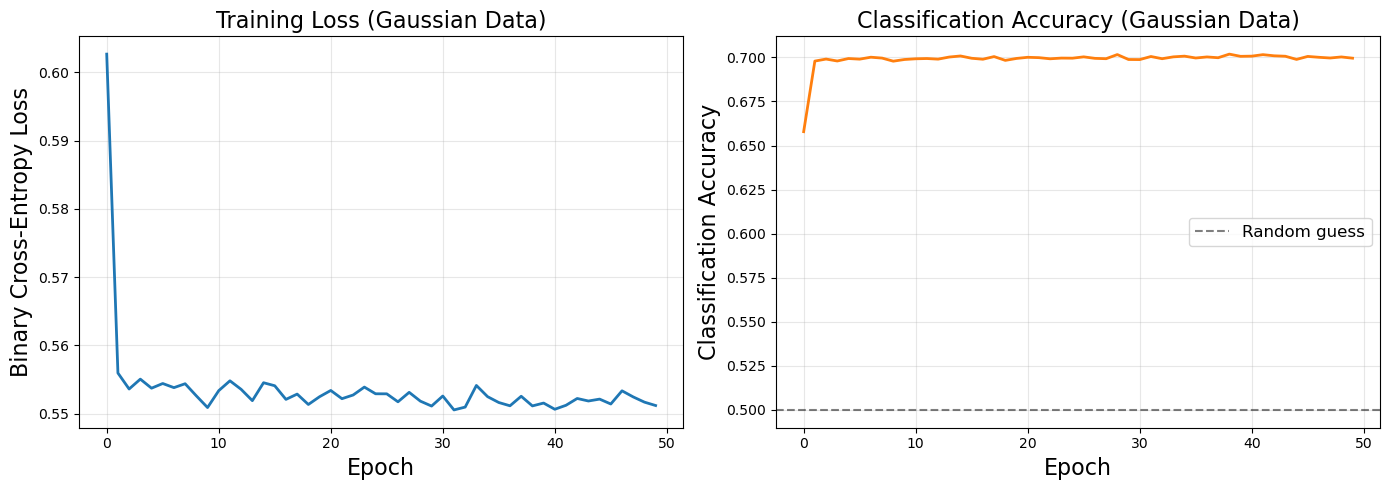

Note: Classification accuracy is not the main objective.
We focus on how well the learned ratio approximates the true posterior.


In [7]:
# Plot training metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(losses_gauss, linewidth=2, color='C0')
axes[0].set_xlabel('Epoch', fontsize=16)
axes[0].set_ylabel('Binary Cross-Entropy Loss', fontsize=16)
axes[0].set_title('Training Loss (Gaussian Data)', fontsize=16)
axes[0].grid(alpha=0.3)

axes[1].plot(accs_gauss, linewidth=2, color='C1')
axes[1].set_xlabel('Epoch', fontsize=16)
axes[1].set_ylabel('Classification Accuracy', fontsize=16)
axes[1].set_title('Classification Accuracy (Gaussian Data)', fontsize=16)
axes[1].axhline(0.5, color='k', linestyle='--', label='Random guess', alpha=0.5)
axes[1].legend(fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Classification accuracy is not the main objective.")
print("We focus on how well the learned ratio approximates the true posterior.")

## 4. Posterior Sampling with MCMC and Nested Sampling

**Key difference from NPE**: Like NLE (Tutorial 2), we need to use **sampling algorithms** to obtain the posterior. We have the ratio $r(x, \theta)$, which gives us the unnormalized posterior $p(\theta|x) \propto r(x, \theta) \cdot p(\theta)$.

We'll implement two sampling approaches:
1. **MCMC with emcee**: Ensemble sampler for exploring the posterior
2. **Nested Sampling with dynesty**: Computes both posterior samples and evidence

In [8]:
def log_likelihood_ratio_fn(theta, x_obs, model):
    """Compute the ratio r(x_obs, θ) using the trained ratio estimator."""
    theta_tensor = torch.tensor([theta], dtype=torch.float32).reshape(-1, 1)
    x_tensor = torch.tensor([x_obs], dtype=torch.float32).reshape(-1, 1)
    with torch.no_grad():
        log_r = model.log_ratio(x_tensor, theta_tensor).item()
    return log_r

def log_prior_uniform(theta, theta_min=-3, theta_max=3):
    """Uniform prior."""
    if theta_min < theta < theta_max:
        return 0.0  # log(1/(theta_max - theta_min)) + constant
    return -np.inf

def log_posterior_fn(theta, x_obs, model, theta_min=-3, theta_max=3):
    """Log-posterior: log p(θ|x) = log r(x, θ) + log p(θ)"""
    lp = log_prior_uniform(theta, theta_min, theta_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ratio_fn(theta, x_obs, model)

Define the sampling function, this is similar to Tutorial 2

In [9]:
def sample_with_emcee(model, x_obs, n_walkers=32, n_steps=3000,
                      theta_min=-3, theta_max=3, burn_in=1000):
    """
    Sample from posterior using emcee (MCMC).
    """
    ndim = 1

    # Initialize walkers randomly in prior range
    p0 = np.random.uniform(theta_min, theta_max, size=(n_walkers, ndim))

    # Create sampler
    sampler = emcee.EnsembleSampler(
        n_walkers, ndim, log_posterior_fn,
        args=(x_obs, model, theta_min, theta_max)
    )

    # Run MCMC
    print(f"  Running emcee with {n_walkers} walkers for {n_steps} steps...")
    sampler.run_mcmc(p0, n_steps, progress=False)

    # Get samples (discard burn-in)
    samples = sampler.get_chain(discard=burn_in, flat=True)

    # Compute acceptance fraction
    acc_frac = np.mean(sampler.acceptance_fraction)
    print(f"  Mean acceptance fraction: {acc_frac:.2%}")

    return samples.flatten()

In [10]:
def prior_transform(u, theta_min=-3, theta_max=3):
    """Transform unit cube to prior (for nested sampling)."""
    return theta_min + (theta_max - theta_min) * u

def sample_with_dynesty(model, x_obs, theta_min=-3, theta_max=3,
                       nlive=500, dlogz=0.5):
    """
    Sample from posterior using dynesty (Nested Sampling).
    """
    # Define likelihood for dynesty
    def loglike(theta):
        return log_likelihood_ratio_fn(theta[0], x_obs, model)

    # Define prior transform
    def ptform(u):
        return np.array([prior_transform(u[0], theta_min, theta_max)])

    # Create nested sampler
    print(f"  Running dynesty with {nlive} live points...")
    sampler = NestedSampler(loglike, ptform, ndim=1, nlive=nlive)
    sampler.run_nested(dlogz=dlogz, print_progress=False)

    results = sampler.results

    # Get weighted posterior samples
    weights = np.exp(results['logwt'] - results['logz'][-1])
    samples = dynesty.utils.resample_equal(results.samples, weights)

    print(f"  Log-evidence: {results.logz[-1]:.2f} ± {results.logzerr[-1]:.2f}")

    return samples.flatten()

In [11]:
def plot_posterior_comparison(model, x_val, theta_train, x_train,
                              theta_min=-3, theta_max=3):
    """
    Compare MCMC and Nested Sampling for a given x value.

    Similar to Tutorial 1's plot_posterior_comparison, but here we need to
    run sampling algorithms since we have r(x, θ) instead of p(θ|x).
    """
    print(f"\nSampling posterior for x={x_val:.2f}")
    print("=" * 50)

    # MCMC sampling
    print("[1/2] MCMC (emcee):")
    mcmc_samples = sample_with_emcee(model, x_val,
                                     theta_min=theta_min, theta_max=theta_max)

    # Nested sampling
    print("\n[2/2] Nested Sampling (dynesty):")
    ns_samples = sample_with_dynesty(model, x_val,
                                     theta_min=theta_min, theta_max=theta_max)

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # True posterior (from training data)
    x_margin = 0.15
    mask = np.abs(x_train - x_val) < x_margin
    theta_true = theta_train[mask]

    # MCMC
    axes[0].hist(mcmc_samples, bins=50, density=True, histtype='step',
                label='MCMC', color='C0', lw=4)
    axes[0].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[0].set_xlabel(r'$\theta$', fontsize=16)
    axes[0].set_ylabel('Density', fontsize=16)
    axes[0].set_title(f'MCMC: $p(\\theta|x={x_val:.2f})$', fontsize=16)
    axes[0].legend(fontsize=12)
    axes[0].grid(alpha=0.3)

    # Nested Sampling
    axes[1].hist(ns_samples, bins=50, density=True, histtype='step',
                label='Nested Sampling', color='C1', lw=4)
    axes[1].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[1].set_xlabel(r'$\theta$', fontsize=16)
    axes[1].set_ylabel('Density', fontsize=16)
    axes[1].set_title(f'Nested Sampling: $p(\\theta|x={x_val:.2f})$', fontsize=16)
    axes[1].legend(fontsize=12)
    axes[1].grid(alpha=0.3)

    # Overlay comparison
    axes[2].hist(mcmc_samples, bins=50, density=True, alpha=0.8,
                label='MCMC', color='C0', histtype='step', lw=4)
    axes[2].hist(ns_samples, bins=50, density=True, alpha=0.8,
                label='Nested Sampling', color='C1', histtype='step', lw=4)
    axes[2].hist(theta_true, bins=30, density=True, alpha=0.2,
                color='k', label='True', zorder=0)
    axes[2].set_xlabel(r'$\theta$', fontsize=16)
    axes[2].set_ylabel('Density', fontsize=16)
    axes[2].set_title('Comparison', fontsize=16)
    axes[2].legend(fontsize=12)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return mcmc_samples, ns_samples


Sampling posterior for x=0.50
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...


/tmp/ipykernel_34093/4041028316.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  theta_tensor = torch.tensor([theta], dtype=torch.float32).reshape(-1, 1)


  Mean acceptance fraction: 80.96%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.59 ± 0.08


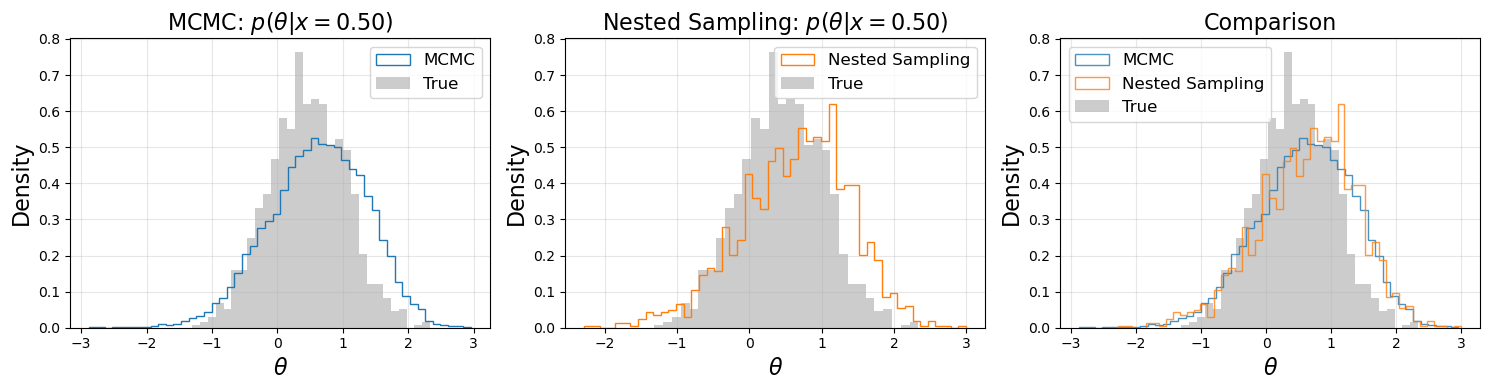

In [12]:
# Test on Gaussian data
test_x = 0.5
mcmc_gauss, ns_gauss = plot_posterior_comparison(
    ratio_estimator_gauss, test_x, theta_joint, x_joint)

---
# Part 2: Ratio Estimation on Half-Moon Data

Now let's see how NRE performs on the half-moon distribution from Tutorials 1 and 2. 

**Key observation**: Unlike Tutorials 1 and 2 where we needed flows for the half-moon, NRE with a simple classifier can still capture complex distributions because it only needs to **classify** joint vs independent samples, not model the full density!

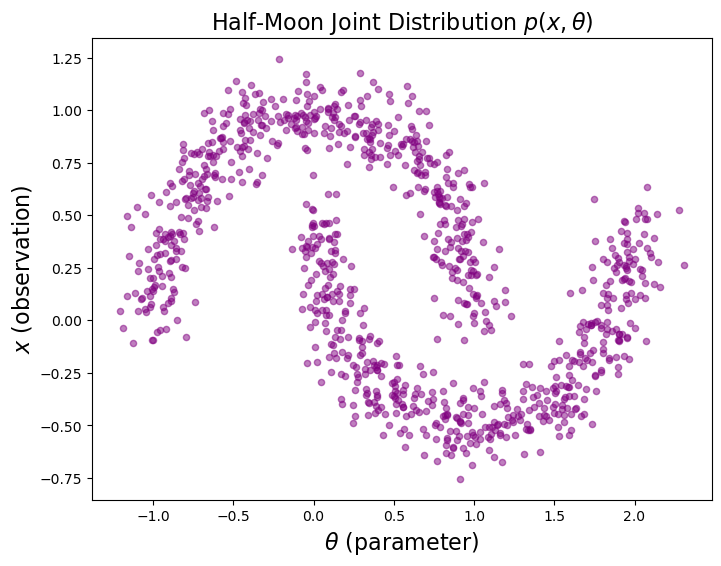

Sampled 1000 points from half-moon
θ range: [-1.21, 2.31]
x range: [-0.75, 1.24]


In [13]:
def sample_halfmoon_joint(n_samples, noise=0.1):
    """
    Sample from half-moon joint distribution p(x, θ).

    Same data generator as Tutorials 1 and 2.

    Returns:
    - theta: parameter values (1D)
    - x: observation values (1D)
    """
    samples, labels = make_moons(n_samples=n_samples, noise=noise, random_state=None)
    theta = samples[:, 0]  # First dimension
    x = samples[:, 1]      # Second dimension
    return theta, x

# Visualize
theta_moon_vis, x_moon_vis = sample_halfmoon_joint(1000)

plt.figure(figsize=(8, 6))
plt.scatter(theta_moon_vis, x_moon_vis, alpha=0.5, s=20, color='purple')
plt.xlabel(r'$\theta$ (parameter)', fontsize=16)
plt.ylabel(r'$x$ (observation)', fontsize=16)
plt.title(r'Half-Moon Joint Distribution $p(x, \theta)$', fontsize=16)
plt.show()

print(f"Sampled {len(theta_moon_vis)} points from half-moon")
print(f"θ range: [{theta_moon_vis.min():.2f}, {theta_moon_vis.max():.2f}]")
print(f"x range: [{x_moon_vis.min():.2f}, {x_moon_vis.max():.2f}]")

In [14]:
# Generate training data from half-moon
n_training = 10_000
print(f"Generating {n_training} training samples from half-moon...\n")

# Joint samples
theta_joint_moon, x_joint_moon = sample_halfmoon_joint(n_training, noise=0.1)

# Independent samples (shuffle to break correlation)
theta_indep_moon = theta_joint_moon.copy()
x_indep_moon = np.random.permutation(x_joint_moon)

print(f"✓ Training data generated")
print(f"  Joint samples: {len(theta_joint_moon)}")
print(f"  Independent samples: {len(theta_indep_moon)}")

Generating 10000 training samples from half-moon...

✓ Training data generated
  Joint samples: 10000
  Independent samples: 10000


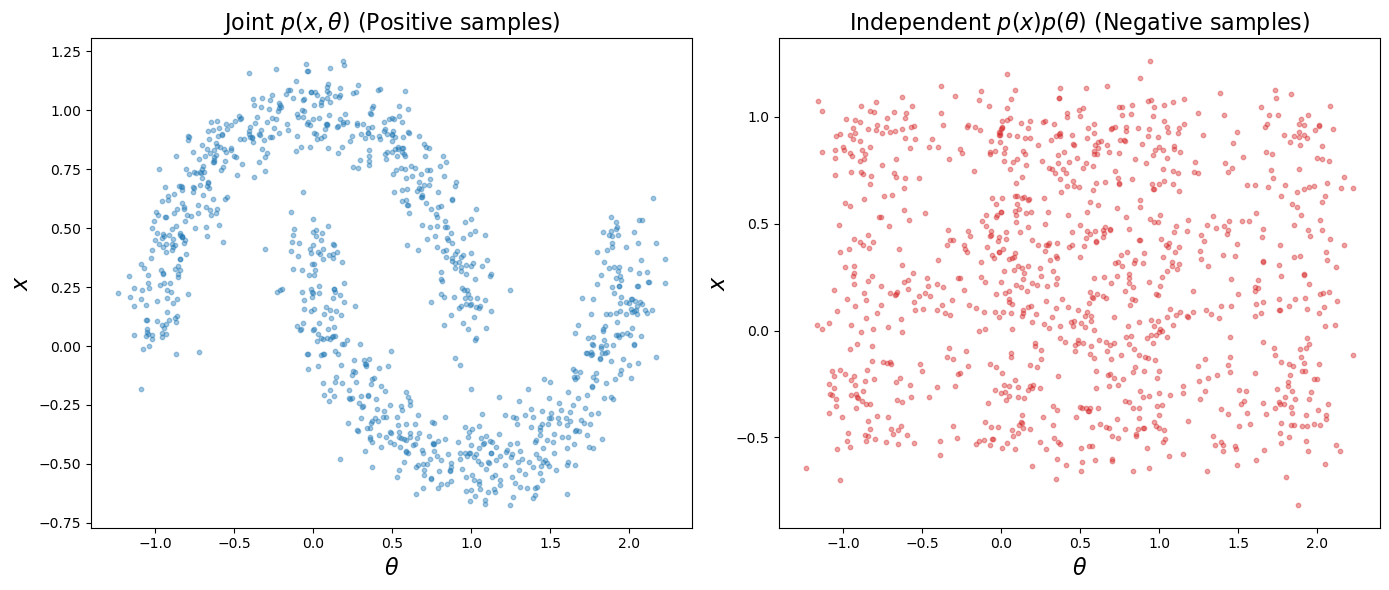

In [15]:
# Visualize joint vs independent samples for half-moon
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(theta_joint_moon[:1000], x_joint_moon[:1000], alpha=0.4, s=10, color='C0')
axes[0].set_xlabel(r'$\theta$', fontsize=16)
axes[0].set_ylabel(r'$x$', fontsize=16)
axes[0].set_title(r'Joint $p(x, \theta)$ (Positive samples)', fontsize=16)

axes[1].scatter(theta_indep_moon[:1000], x_indep_moon[:1000], alpha=0.4, s=10, color='C3')
axes[1].set_xlabel(r'$\theta$', fontsize=16)
axes[1].set_ylabel(r'$x$', fontsize=16)
axes[1].set_title(r'Independent $p(x)p(\theta)$ (Negative samples)', fontsize=16)

plt.tight_layout()
plt.show()

## 5. Train Ratio Estimator on Half-Moon

We'll train the same classifier architecture on the half-moon data.

In [16]:
ratio_estimator_moon = RatioEstimator(hidden_size=64)
losses_moon, accs_moon = train_ratio_estimator(
    ratio_estimator_moon, theta_joint_moon, x_joint_moon, theta_indep_moon, x_indep_moon, epochs=50)

Training for 50 epochs...

Epoch  10/50 | Loss: 0.5217 | Accuracy: 73.01%
Epoch  20/50 | Loss: 0.5109 | Accuracy: 73.73%
Epoch  30/50 | Loss: 0.5073 | Accuracy: 73.75%
Epoch  40/50 | Loss: 0.5046 | Accuracy: 74.02%
Epoch  50/50 | Loss: 0.5044 | Accuracy: 73.85%

✓ Training complete!


## 6. Evaluate: Posterior on Half-Moon with Sampling

Let's see how well the ratio estimator captures the complex half-moon posterior using MCMC and nested sampling, **without using flows**!


Sampling posterior for x=0.50
[1/2] MCMC (emcee):
  Running emcee with 32 walkers for 3000 steps...
  Mean acceptance fraction: 47.09%

[2/2] Nested Sampling (dynesty):
  Running dynesty with 500 live points...
  Log-evidence: -0.06 ± 0.08


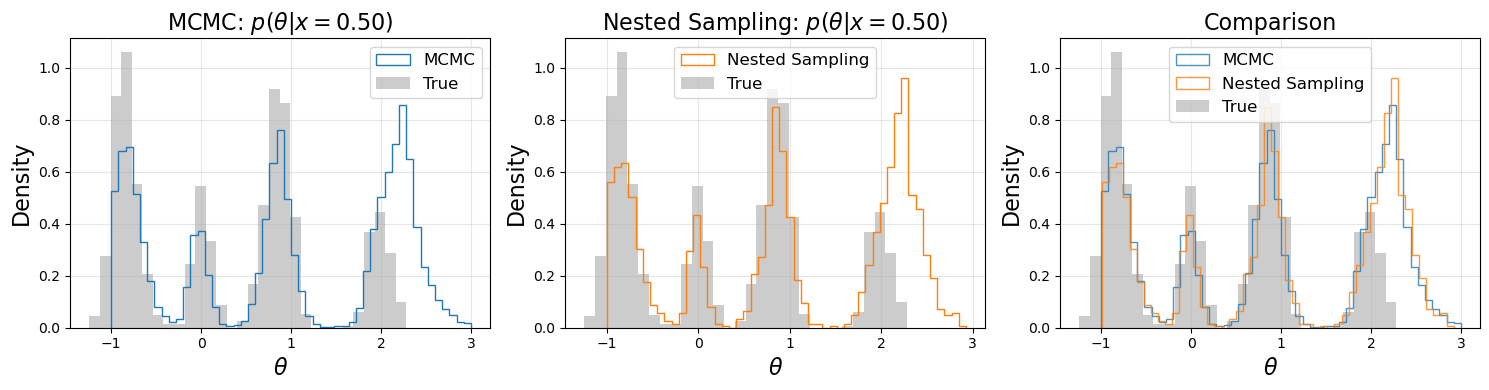

In [17]:
# Test on half-moon data with MCMC and Nested Sampling
test_x_moon = 0.5
mcmc_moon, ns_moon = plot_posterior_comparison(
    ratio_estimator_moon, test_x_moon, theta_joint_moon, x_joint_moon,
    theta_min=-1, theta_max=3)

Visualizing classifier decision boundary...



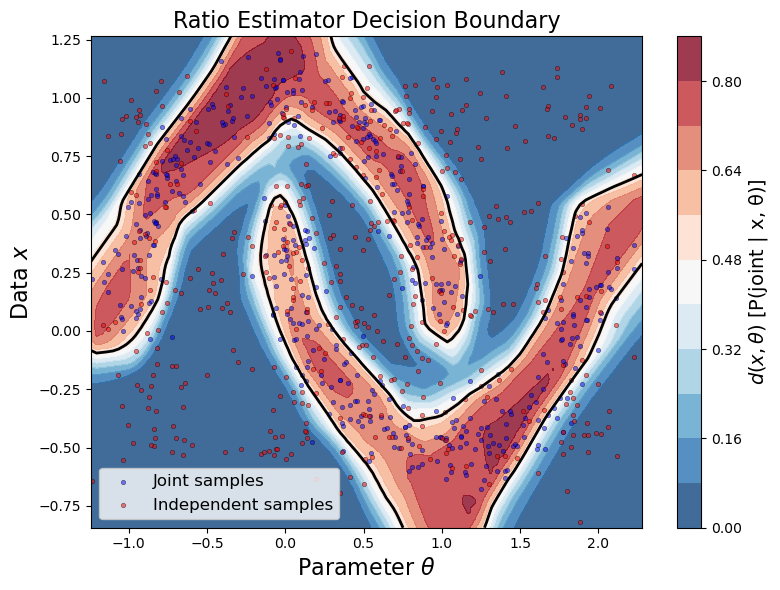

In [18]:
# Visualize the decision boundary of the classifier
print("Visualizing classifier decision boundary...\n")

# Create a grid
theta_grid = np.linspace(theta_joint_moon.min(), theta_joint_moon.max(), 100)
x_grid = np.linspace(x_joint_moon.min(), x_joint_moon.max(), 100)
theta_mesh, x_mesh = np.meshgrid(theta_grid, x_grid)

# Evaluate classifier on grid
theta_flat = theta_mesh.flatten()
x_flat = x_mesh.flatten()
theta_tensor = torch.tensor(theta_flat, dtype=torch.float32).reshape(-1, 1)
x_tensor = torch.tensor(x_flat, dtype=torch.float32).reshape(-1, 1)

with torch.no_grad():
    probs = ratio_estimator_moon(x_tensor, theta_tensor).squeeze().numpy()

probs_mesh = probs.reshape(theta_mesh.shape)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot decision boundary
contour = ax.contourf(theta_mesh, x_mesh, probs_mesh, levels=10, cmap='RdBu_r', alpha=0.8)
ax.contour(theta_mesh, x_mesh, probs_mesh, levels=[0.5], colors='k', linewidths=2)

# Overlay training data
ax.scatter(theta_joint_moon[:500], x_joint_moon[:500], alpha=0.5, s=10,
           label='Joint samples', color='blue', edgecolor='k', linewidth=0.5)
ax.scatter(theta_indep_moon[:500], x_indep_moon[:500], alpha=0.5, s=10,
           label='Independent samples', color='red', edgecolor='k', linewidth=0.5)

ax.set_xlabel(r'Parameter $\theta$', fontsize=16)
ax.set_ylabel(r'Data $x$', fontsize=16)
ax.set_title('Ratio Estimator Decision Boundary', fontsize=16)
ax.legend(fontsize=12)

# Add colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label(r'$d(x, \theta)$ [P(joint | x, θ)]', fontsize=14)

plt.tight_layout()
plt.show()

---
## Summary

In this tutorial, we explored Neural Ratio Estimation (NRE) and demonstrated its effectiveness on both Gaussian and non-Gaussian data.

### What We Demonstrated

**Part 1: Ratio Estimation on Gaussian Data**
- Trained a binary classifier to distinguish joint samples $p(x, \theta)$ from independent samples $p(x)p(\theta)$
- Used the classifier to compute the likelihood ratio $r(x, \theta)$
- Used MCMC and Nested Sampling to obtain posterior samples
- Achieved accurate posterior estimates

**Part 2: Ratio Estimation on Half-Moon Data**
- Applied the same classifier to non-Gaussian data
- **Successfully captured complex posterior structure without flows!**
- Both MCMC and Nested Sampling produced accurate posteriors

### Comparison with Previous Tutorials

| Aspect | NPE (Tutorial 1) | NLE (Tutorial 2) | NRE (Tutorial 3) |
|--------|------------------|------------------|------------------|
| **What we learn** | $p(\theta\|x)$ | $p(x\|\theta)$ | $r(x,\theta) = \frac{p(x,\theta)}{p(x)p(\theta)}$ |
| **Model type** | Density model | Density model | Binary classifier |
| **Inference** | Direct sampling | MCMC/Nested Sampling | MCMC/Nested Sampling |
| **Flexibility** | Needs flows for complex posteriors | Needs flows for complex likelihoods | Simple classifier works! |
| **Training data** | $(x, \theta)$ pairs | $(x, \theta)$ pairs | Joint + Independent pairs |
| **Advantage** | Fast direct sampling | Flexible sampling | No density modeling needed |

### Key Advantages of NRE

1. **No density modeling**: Only needs to classify, not model full distributions
2. **Simple architecture**: Works well without flows, even for complex distributions
3. **Sample efficient**: Often needs fewer training samples than NPE/NLE
4. **Interpretable**: The classifier directly learns what distinguishes joint from independent samples

### Key Disadvantages of NRE

1. **Requires negative samples**: Must generate samples from $p(x)p(\theta)$
2. **Requires sampling**: Like NLE, needs MCMC or nested sampling for inference (except for very low-dimensional $\theta$ where grid evaluation is feasible)
3. **Ratio instability**: Can be numerically unstable when classifier is very confident

### When to Use NRE?

- **Use NRE** when:
  - You want a simple model without flows
  - You can easily generate independent samples
  - You're comfortable with MCMC/Nested Sampling
  - Sample efficiency is important

- **Use NPE (Tutorial 1)** when:
  - You want fast inference via direct sampling
  - You have high-dimensional parameters
  - You're willing to use flow models

- **Use NLE (Tutorial 2)** when:
  - Likelihood modeling is more natural for your problem
  - You need evidence estimates
  - You want maximum flexibility in choosing sampling algorithms

### Key Takeaway

**NRE is a powerful alternative that trades density modeling for classification.** This makes it remarkably effective at capturing complex distributions without requiring normalizing flows. The main advantage over NPE and NLE is that the classifier can be much simpler (no flows needed), while the main similarity with NLE is that both require sampling for inference.

**For problems where sampling is acceptable and you want the simplest possible model, NRE is an excellent choice!**